In [1]:
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2022-12-11 08:19:43--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‘bbc_text_cls.csv’

bbc_text_cls.csv    100%[===================>]   4.85M  29.9MB/s    in 0.2s    

2022-12-11 08:19:43 (29.9 MB/s) - ‘bbc_text_cls.csv’ saved [5085081/5085081]



In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

import nltk 
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import string

In [9]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
df = pd.read_csv("bbc_text_cls.csv")

In [4]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [5]:
df["labels"].astype("category").cat.codes

0       0
1       0
2       0
3       0
4       0
       ..
2220    4
2221    4
2222    4
2223    4
2224    4
Length: 2225, dtype: int8

In [6]:
df["targets"] = df["labels"].astype("category").cat.codes

In [7]:
df_train, df_test = train_test_split(df, test_size=0.33)

In [10]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

class LemmaTokenizer:
  def __init__(self):
    self.wnl = WordNetLemmatizer()
    self.stopwords = set(stopwords.words("english"))
  def __call__(self, doc):
    doc = doc.rstrip().lower()
    if doc:
      doc = doc.translate(str.maketrans('', '', string.punctuation))
      tokens = word_tokenize(doc)
      words_and_tags = nltk.pos_tag(tokens)
      tokens = [t for t in tokens if len(t) > 2]
      tokens = [self.wnl.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in words_and_tags]
      tokens = [t for t in tokens if t not in self.stopwords]
      tokens = [t for t in tokens if not any(c.isdigit() for c in t)]
      return tokens

In [11]:
vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer())
Xtrain = vectorizer.fit_transform(df_train["text"])
Xtest = vectorizer.transform(df_test["text"])

In [12]:
Ytrain = df_train["targets"]
Ytest = df_test["targets"]

In [13]:
K = df["targets"].max() + 1
K

5

In [17]:
D = Xtrain.shape[1]
Xtrain = Xtrain.toarray()
Xtest = Xtest.toarray()

In [51]:
i = Input(shape=(D,))
x = Dense(300, activation="elu")(i)
x = Dense(150, activation="elu")(x)
x = Dense(100, activation="elu")(x)
x = Dense(K)(x)

model = Model(i, x)

In [52]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 21495)]           0         
                                                                 
 dense_15 (Dense)            (None, 300)               6448800   
                                                                 
 dense_16 (Dense)            (None, 150)               45150     
                                                                 
 dense_17 (Dense)            (None, 100)               15100     
                                                                 
 dense_18 (Dense)            (None, 5)                 505       
                                                                 
Total params: 6,509,555
Trainable params: 6,509,555
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)


ft = model.fit(
    Xtrain, Ytrain,
    validation_data=(Xtest, Ytest),
    epochs=7,
    batch_size=128
)

Epoch 1/7
12/12 [==============================] - 2s 150ms/step - loss: 1.2096 - accuracy: 0.7899 - val_loss: 0.5432 - val_accuracy: 0.9633
Epoch 2/7
12/12 [==============================] - 1s 118ms/step - loss: 0.1731 - accuracy: 0.9973 - val_loss: 0.0907 - val_accuracy: 0.9823
Epoch 3/7
12/12 [==============================] - 1s 120ms/step - loss: 0.0096 - accuracy: 0.9993 - val_loss: 0.0641 - val_accuracy: 0.9837
Epoch 4/7
12/12 [==============================] - 1s 124ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0633 - val_accuracy: 0.9837
Epoch 5/7
12/12 [==============================] - 1s 118ms/step - loss: 5.1470e-04 - accuracy: 1.0000 - val_loss: 0.0638 - val_accuracy: 0.9837
Epoch 6/7
12/12 [==============================] - 1s 122ms/step - loss: 3.5204e-04 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9850
Epoch 7/7
12/12 [==============================] - 1s 119ms/step - loss: 2.8918e-04 - accuracy: 1.0000 - val_loss: 0.0634 - val_accuracy: 0.9850


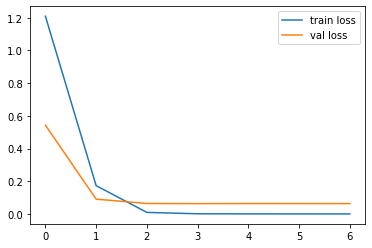

In [54]:
plt.plot(ft.history["loss"], label="train loss")
plt.plot(ft.history["val_loss"], label="val loss")
plt.legend();

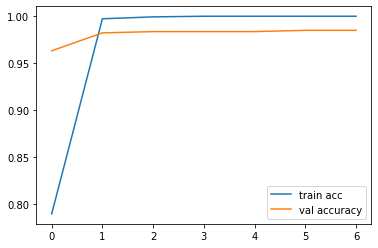

In [55]:
plt.plot(ft.history["accuracy"], label="train acc")
plt.plot(ft.history["val_accuracy"], label="val accuracy")
plt.legend();

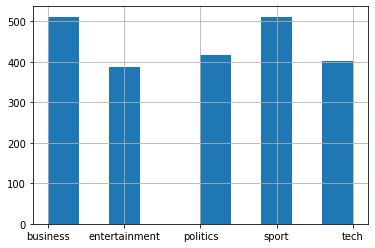

In [56]:
df["labels"].hist();